<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Monte-Carlo-learning" data-toc-modified-id="Monte-Carlo-learning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Monte Carlo learning</a></span><ul class="toc-item"><li><span><a href="#First-Visit-Monte-Carlo-Policy-Evaluation" data-toc-modified-id="First-Visit-Monte-Carlo-Policy-Evaluation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>First-Visit Monte-Carlo Policy Evaluation</a></span></li><li><span><a href="#Every-Visit-Monte-Carlo-Policy-Evaluation" data-toc-modified-id="Every-Visit-Monte-Carlo-Policy-Evaluation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Every-Visit Monte-Carlo Policy Evaluation</a></span></li></ul></li><li><span><a href="#Temporal-Difference-learning" data-toc-modified-id="Temporal-Difference-learning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Temporal Difference learning</a></span></li><li><span><a href="#TD(λ)" data-toc-modified-id="TD(λ)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>TD(λ)</a></span></li></ul></div>

In [1]:
%matplotlib inline
from collections import defaultdict
from typing import Callable, Any
import numpy as np
import pandas as pd
import gym
import time
import cufflinks
env = gym.make('FrozenLake-v0')

In [2]:
obs = env.reset()
env.render()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    env.render()


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


# Introduction
In model-free prediction we solve the task of estimating the state-value or action-value look-up table without assuming any knowledge about the transition matrix $\mathcal{S}$ and the rewards dynamics $\mathcal{R}$ of the Markov Decision Process (MDP) $<\mathcal{S}, \mathcal{A}, \mathcal{P}, \mathcal{R}, \lambda>$. This makes the algorithms applicable in the real world, were we generally don't know the dynamics of the environment.

# Monte Carlo learning

Monte Carlo (MC) learns from complete finite episodes (no bootstrapping) from the simplest possible idea: sample episodes and calculate the empirical mean of state-value or action-values. By definition $v_π(s) \doteq \mathbb{E}_π [G_t | S_t = s]$. MC replace the expectation with an average.

In [3]:
def policy_random(env: gym.Env, obs: Any):
    return env.action_space.sample()


def generate_trajectory(env: gym.Env, policy: Callable, seed: int=0):
    states, actions, rewards = [], [], []
    
    env.seed(seed)
    obs = env.reset()
    states.append(obs)
    done = False
    while not done:
        action = policy(env, obs)
        obs, reward, done, info = env.step(action)
        states.append(obs)
        actions.append(action)
        rewards.append(reward)
    actions.append(None)
    rewards.append(None)
    return states, actions, rewards


def monte_carlo_leaning(policy: Callable, n_trajectories: int=1000, is_first_visit_mc: bool=True, gamma: int=1, alpha: float=None):
    """Set alpha is the problem is not stationary (to slowly forget the past with EWMA), empirical mean if none."""
    N = defaultdict(int)
    V = defaultdict(float)
    V_history = dict()
    for nr_episode in range(n_trajectories):
        states, actions, rewards = generate_trajectory(env, policy, seed=nr_episode)
        for t in range(len(states) - 1):  # -1 to avoid terminal state
            state = states[t]
            action = actions[t]
            reward = rewards[t]
            is_already_visited = state in states[:t]
            if is_first_visit_mc and is_already_visited:
                continue
            N[state] += 1
            coeff = 1 / N[state] if alpha is None else alpha
            G_t = sum(r * gamma ** i for i, r in enumerate(rewards[t:-1]))
            target = G_t
            
            V[state] = V[state] + coeff * (target - V[state])  # running mean
                
        # Update state-value look-up table.
        V_history[nr_episode] = V.copy()

    return pd.DataFrame(V_history).T

## First-Visit Monte-Carlo Policy Evaluation

State-value look-up table:


,0,1,2,3
0,0.01399,0.0117452,0.0210699,0.00984654
1,0.0164048,,0.0419487,
2,0.0348336,0.0909498,0.141703,
3,,0.180907,0.44611,


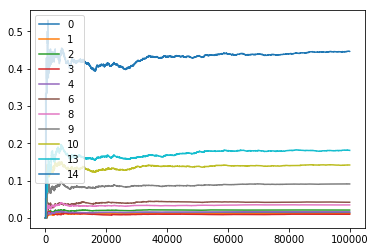

In [4]:
V_history = monte_carlo_leaning(policy=policy_random, gamma=1, n_trajectories=100000, is_first_visit_mc=True)
V_history.plot()
print('State-value look-up table:')
pd.DataFrame(V_history.iloc[-1].combine_first(pd.Series('', index=range(16))).values.reshape(4, 4)).round(4)

## Every-Visit Monte-Carlo Policy Evaluation

In [ ]:
V_history = monte_carlo_leaning(policy=policy_random, gamma=1, n_trajectories=100000, is_first_visit_mc=False)
V_history.plot()
print('State-value look-up table:')
pd.DataFrame(V_history.iloc[-1].combine_first(pd.Series('', index=range(16))).values.reshape(4, 4)).round(4)

# Temporal Difference learning
TD learns from incomplete episodes, by bootstrapping

In [ ]:
def policy_random(env: gym.Env, obs: Any):
    return env.action_space.sample()


def monte_carlo_leaning(policy: Callable, n_trajectories: int=1000, is_every_visit_mc: bool=True, gamma: int=1, alpha: float=None, lambda_: float=0):
    """Set alpha is the problem is not stationary (to slowly forget the past with EWMA), empirical mean if none."""
    N = defaultdict(int)
    V = defaultdict(float)
    V_history = dict()
    for nr_episode in range(n_trajectories):
        obs = env.reset()
        done = False
        states, actions, rewards = [obs], [None], [None]
        while not done:
            # <Start> interact with the environment
            old_obs = obs
            action = policy(env, obs)
            obs, reward, done, info = env.step(action)
            states.append(obs)
            actions.append(action)
            rewards.append(reward)
            # <End> interact with the environment
            
            # <Start> Update state-values.
            if lambda_ == 0:
                # Monte Carlo.
                if done:
                    nr_steps = len(actions)
                    for t in range(nr_steps):
                        not_visited_yet = states[t] not in states[:t]
                        if is_every_visit_mc or not_visited_yet:
                            N[states[t]] += 1
                            coeff = 1 / N[states[t]] if alpha is None else alpha
                            G_t = sum(r * gamma ** i for i, r in enumerate(rewards[t+1:]))
                            target = G_t
                            V[old_obs] = V[old_obs] + coeff * (target - V[old_obs])  # running mean
            elif lambda_ == 1:
                # Temporal-Difference.
                N[old_obs] += 1
                coeff = 1 / N[old_obs] if alpha is None else alpha
                target = reward + gamma * V[obs]
                V[old_obs] = V[old_obs] + coeff * (target - V[old_obs])  # running mean
            else:
                raise ValueError('TD(lambda) not supported just yet.')
            
            
        # Update state-value look-up table.
        V_history[nr_episode] = V.copy()

    return pd.DataFrame(V_history).T

In [ ]:
monte_carlo_leaning(policy=policy_random, n_trajectories=5, is_every_visit_mc=True, gamma=1, alpha=None, lambda_=1)

# TD(λ)